<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="BS"></a><h1 style="text-align:center;">Integrated Volterra Square-root Process and Volterra Heston Model </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>


We consider an non-decreasing Volterra process $U$ of the form:
$$
U_t = \int_0^t g_0(s) ds + \int_0^t K(t-s) (b U_sds + c W_{U_s} ds)
$$
where  $K$ is a locally integrable kernel ($L^1([0,T])$, not necessarily $L^2$) $  c \geq 0$ and $b \in \mathbb R$, $W_t$ is a standard Brownian motion and $g_0$ a suitable input curve. We will take:
$$ g_0(t) = V_0 + a \int_0^t K(r)dr, $$
with $a,V_0 \geq 0$. 

If $K\in L^2([0,T])$, then one can show using stochastic Fubini's theorem that $U$ is absolutely continuous with respect to the Lebesgue measure, i.e. $U = \int_0^{\cdot} V_s ds$ almost surely, and that the nonnegative density process $V$ satisfies a square-root stochastic Volterra equation in the form
$$ V_t = g_0(t) + \int_0^t K(t-s) (b V_s ds + c\sqrt{V_s}dW_s) = V_0 + \int_0^t K(t-s) ((a + b V_s) ds + c\sqrt{V_s}dW_s). $$
In particular for the fractional kernel 
$$ K_H(t) = \frac{1}{\Gamma(H+0.5)}t^{H-1/2}, $$
with $H \in (0,1/2]$ one recovers the rough square-root process used for instance to model the instanteneous variance of a stock.  In this case, $X$ plays the role of the integrated variance. 

If $H \in (-1/2,0]$, $K_H$ is no longer in $L^2$ but only in $L^1$ but still the equation for $U$ makes sense, but $U$ is no longer absolutely continuous with respect to the Lebsegue measure, and the process $V$ no longer makes sense.

In the sequel, we develop a simple scheme to simulate $U$ for any kernel $K \in L^1([0,T])$. We do not consider the process $V$ further. Consequently, the stochastic volatility model
$$
\frac{dS_t}{S_t} = \sqrt{V_t}\, dB_t,
\qquad
B_t = \rho W_t + \sqrt{1-\rho^2}\,W_t^\perp,
\qquad
\rho \in [-1, 1],
$$
where $W^\perp$ is independent of $W$, can be rewritten as
$$
\frac{dS_t}{S_t} = \rho\, dZ_t + \sqrt{1-\rho^2}\, dZ_t^\perp,
$$
where $Z_t := W_{U_t}$ is the martingale appearing in the Volterra equation and
$
Z_t^\perp := \int_0^t \sqrt{U_s}\, dW_s^{\perp}.
$
Given $(U,Z)$, the process $Z^\perp$ can be simulated simply as a Gaussian process with quadratic variation $U$.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
    sys.path.append("../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy

from volterra_hawkes.iVi.iVi_volterra_vol_model import IVIVolterraVolModel
from volterra_hawkes.kernel.fractional_kernel import FractionalKernel
from volterra_hawkes.kernel.exponential_kernel import ExponentialKernel
from volterra_hawkes.kernel.constant_kernel import ConstantKernel

color_cycle = ["#5b6c64", "#B56246", "#322B4D", "#28BC9C", "#71074E"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

## Setting up the model: Rough Heston case

In [2]:
# ---------------------------
# Model parameters
# ---------------------------
H = -0.1                   # Hurst parameter for the fractional kernel
a, b, c = 0.02, -0.3, .3  # Model coefficients
V_0 = 0.02                # Initial variance
rho = -0.7                # Correlation between Brownian motions driving price and variance

# ---------------------------
# Simulation setup
# ---------------------------
T = 1                    # Time horizon
n_steps = 300            # Number of time steps
t_grid = np.linspace(0, T, n_steps + 1)  # Discretized time grid

# ---------------------------
# Fractional kernel for Volterra process
# ---------------------------
kernel = FractionalKernel(H=H)  # Kernel operator associated with fractional integration

# ---------------------------
# Initial condition functions for the Volterra model
# ---------------------------
def g0(t):
    """Function g0(t)."""
    return V_0 + a * kernel.integrated_kernel(t)

def g0_bar(t):
    """Integrated version of g0(t)."""
    return V_0 * t + a * kernel.double_integrated_kernel(t)

# ---------------------------
# Model definition
# ---------------------------
rng = np.random.default_rng(seed=42)  # Random number generator for reproducibility
n_paths = 10                          # Number of Monte Carlo paths

# Instantiate the Volterra stochastic volatility model
model = IVIVolterraVolModel(
    is_continuous=True,            # Use the iVi scheme for continuous processes
    resolvent_flag=False,          # Whether to use the resolvent formulation
    kernel=kernel,                 # Volterra kernel
    g0_bar=g0_bar,                 # Integrated g0 as Callable
    rng=rng,                       # Random number generator
    b=b, c=c,                      # Model parameters
    g0=g0,                         # g0 as Callable
    rho=rho                        # Correlation between Brownian motions
)

# ---------------------------
# Simulate asset paths
# ---------------------------
S, U, Z, V = model.simulate_price(n_paths=n_paths, t_grid=t_grid)

# Outputs:
#   S : simulated stock price paths
#   U : integrated variance
#   Z : martingale process
#   V : instantaneous variance


<Figure size 1000x600 with 0 Axes>

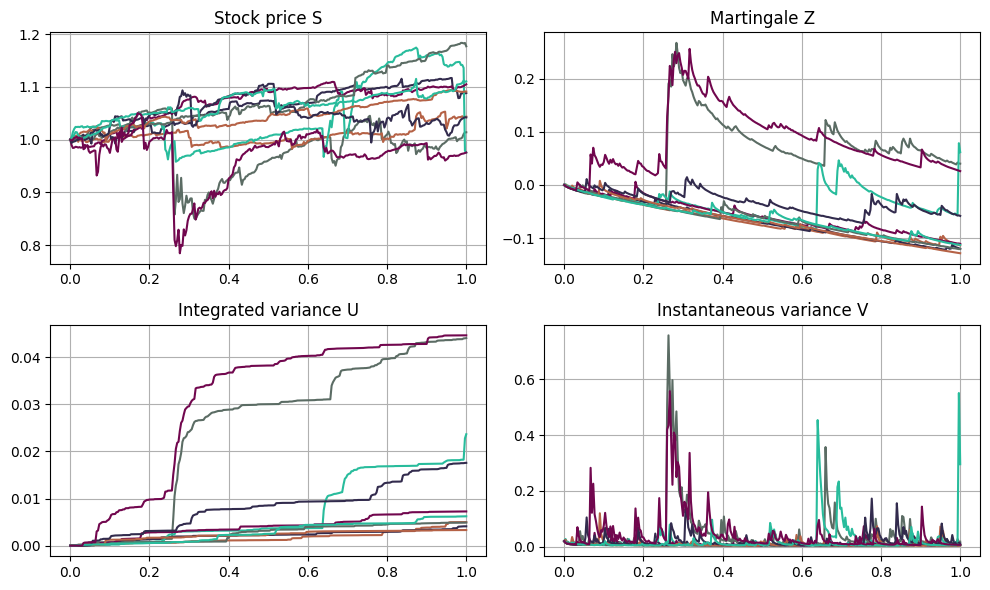

In [3]:
fig = plt.figure(figsize=(10, 6))

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(t_grid, S[:, :n_paths])
axs[0, 0].set_title('Stock price S')

axs[0, 1].plot(t_grid, Z[:, :n_paths])
axs[0, 1].set_title('Martingale Z')

axs[1, 0].plot(t_grid, U[:, :n_paths])
axs[1, 0].set_title('Integrated variance U')

axs[1, 1].plot(t_grid, V[:, :n_paths])
axs[1, 1].set_title('Instantaneous variance V')

plt.show()

## Pricing under the rough Heston model

Parameters as in Figures 1, 4 and 5 from the paper ["On the Discrete-Time Simulation of the Rough Heston Model"](https://epubs.siam.org/doi/pdf/10.1137/21M1443807?casa_token=7as5_DHgp6gAAAAA:J1jlH9d5L2BPaaYkRU4xX-b9bPpk_fz8NY1OLCivmInasR55EPoAzR_-VVgbAfGAifXLGDh1RCEXIQ).

We test the scheme by computing the prices of the following three options:
1. ATM call option $(S_T - K)^+$ with $K = S_0 = 1$ and $T = 1$;
2. Integrated variance $U_T$;
3. Call on integrated variance $(U_T - K_U)^+$ with $K_U = V_0$ and $T = 1$.

In [4]:
%%time
H = 0.1
a, b, c = 0.02, - 0.3, .3
V_0 = 0.02
rho = -0.7
kernel = FractionalKernel(H=H)

def g0_bar(t):
    return V_0 * t + a * kernel.double_integrated_kernel(t)


def g0(t):
    return V_0 + a * kernel.integrated_kernel(t)


rng = np.random.default_rng(seed=42)
model = IVIVolterraVolModel(is_continuous=True, resolvent_flag=False, kernel=kernel,
                            g0_bar=g0_bar, rng=rng, b=b, c=c, g0=g0, rho=rho)

T = 1.
K = 1.
K_U = V_0

n_paths = 100_000
n_steps_list = [1, 10, 20, 30, 40, 50, 60, 70, 100, 200, 300, 500]

# Store results in a dictionary for clarity
results = {
    "call_price": {"mean": [], "std": [], "ref": 0.0572, "label": "Call on price"},
    "U": {"mean": [], "std": [], "ref": 0.028295, "label": "Mean of U"},
    "U_call": {"mean": [], "std": [], "ref": 0.013517, "label": "Call on U"},
}

# Monte Carlo simulations
for n_steps in n_steps_list:
    t_grid = np.linspace(0, T, n_steps + 1)
    S, U, Z, V = model.simulate_price(t_grid=t_grid, n_paths=n_paths)

    # Call on price
    payoff = np.maximum(S[-1] - K, 0.0)
    results["call_price"]["mean"].append(np.mean(payoff))
    results["call_price"]["std"].append(np.std(payoff))

    # Mean of U
    results["U"]["mean"].append(np.mean(U[-1]))
    results["U"]["std"].append(np.std(U[-1]))

    # Call on U
    payoff_U = np.maximum(U[-1] - K_U, 0.0)
    results["U_call"]["mean"].append(np.mean(payoff_U))
    results["U_call"]["std"].append(np.std(payoff_U))

CPU times: user 2min 12s, sys: 47.3 s, total: 2min 59s
Wall time: 21.3 s


In [5]:
# Helper function for plotting with confidence intervals
def plot_with_ci(ax, x, mean, std, n_paths, ref_value, title, color=color_cycle[1], label="MC estimate"):
    mean = np.array(mean)
    std = np.array(std)
    ci = 1.96 * std / np.sqrt(n_paths)

    ax.plot(x, mean, label=label, color=color)
    ax.fill_between(x, mean + ci, mean - ci, alpha=0.1, label="1.96 std", color=color)
    ax.axhline(y=ref_value, color="black", label="Reference value")
    ax.set_title(title)
    ax.legend()

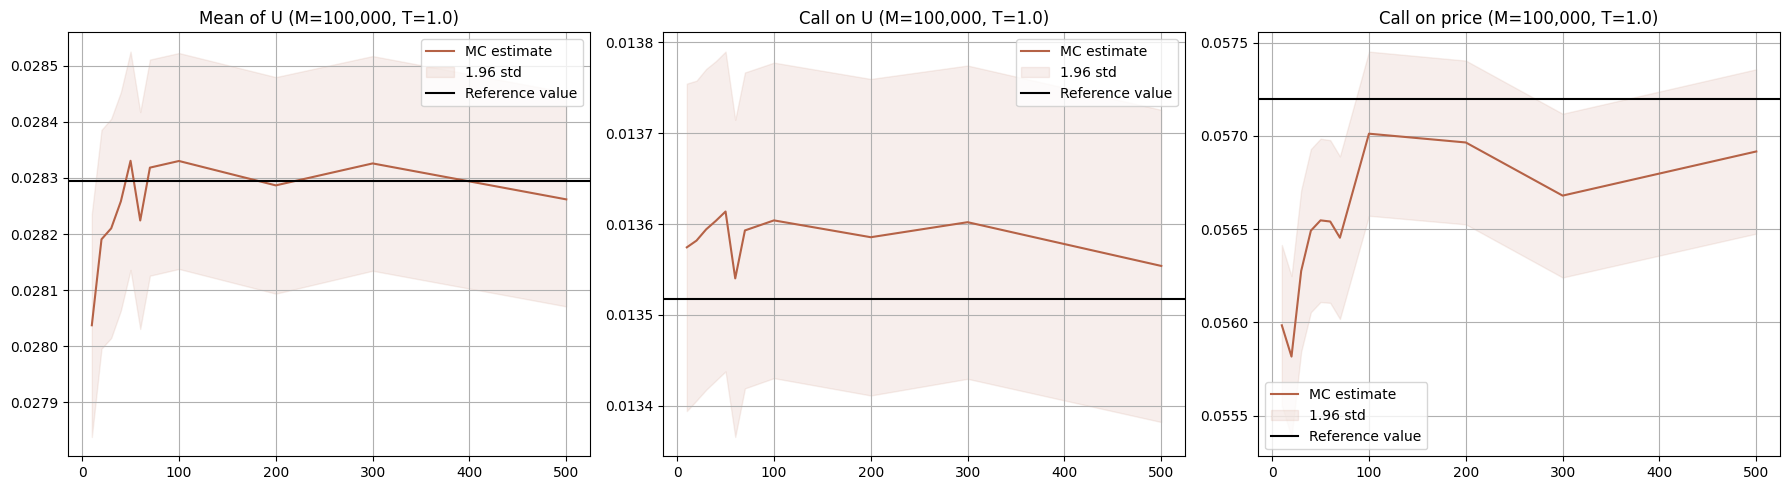

In [6]:
# Plot everything in one figure
start_idx = 1
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plot_with_ci(
    axs[0], n_steps_list[start_idx:], results["U"]["mean"][start_idx:], results["U"]["std"][start_idx:],
    n_paths, results["U"]["ref"], f"{results['U']['label']} (M={n_paths:,}, T={T})"
)

plot_with_ci(
    axs[1], n_steps_list[start_idx:], results["U_call"]["mean"][start_idx:], results["U_call"]["std"][start_idx:],
    n_paths, results["U_call"]["ref"], f"{results['U_call']['label']} (M={n_paths:,}, T={T})"
)

plot_with_ci(
    axs[2], n_steps_list[start_idx:], results["call_price"]["mean"][start_idx:], results["call_price"]["std"][start_idx:],
    n_paths, results["call_price"]["ref"], f"{results['call_price']['label']} (M={n_paths:,}, T={T})"
)

plt.tight_layout()
plt.show()

## Markovian case: standard Heston model

The standard Heston model
$$
V_t = V_0 + \int_0^t (a + b V_s) \, ds + c\sqrt{V_s}\,dW_s,
$$
can be written as a Volterra Heston model with exponential kernel $K(t) = e^{bt}$:
$$
V_t = e^{bt}V_0 + a\int_0^t e^{bs} \, ds + c\int_0^t e^{b(t-s)}\sqrt{V_s}\,dW_s = g_0(t) + c\int_0^t K(t-s)\sqrt{V_s}\,dW_s,
$$
with $g_0(t) = e^{bt}V_0 + a\int_0^t e^{bs} \, ds$.

As a sanity check, we compute the prices of three call options with strikes $K \in \{60, 100, 140\}$ and maturity $T = 1$, and compare them to the reference values taken from [the paper](https://hal.science/hal-04839193v1/file/Heston_simulation_made_simple_.pdf) on the iVi Heston scheme. The initial price is $S_0 = 100$.

In [7]:
V_0 = 0.006
a = 17.25 * 0.018
b = -17.25
c = 2.95
rho = -0.68
S0 = 100

kernel = ExponentialKernel(c=1, lam=-b)

def g0_bar(t):
    return V_0 * kernel.integrated_kernel(t) + a * kernel.double_integrated_kernel(t)

def g0(t):
    return V_0 * kernel(t) + a * kernel.integrated_kernel(t)


rng = np.random.default_rng(seed=42)
model = IVIVolterraVolModel(is_continuous=True, resolvent_flag=False, kernel=kernel,
                            g0_bar=g0_bar, rng=rng, b=0, c=c, g0=g0, rho=rho)

T = 1.

n_paths = 100_000
n_steps_list = [1, 10, 20, 30, 40, 50, 60, 70, 100, 200, 300, 500]

# Store results in a dictionary for clarity
results = {
    "call_K=60": {"mean": [], "std": [], "ref": 40.1163, "label": "Call with K = 60"},
    "call_K=100": {"mean": [], "std": [], "ref": 4.3454, "label": "Call with K = 100"},
    "call_K=140": {"mean": [], "std": [], "ref": 0.0015, "label": "Call with K = 140"},
}

# Monte Carlo simulations
for n_steps in n_steps_list:
    t_grid = np.linspace(0, T, n_steps + 1)
    S, U, Z, V = model.simulate_price(t_grid=t_grid, n_paths=n_paths, S0=S0)

    # Call on price
    for K, name in zip([60, 100, 140], results.keys()):
        payoff = np.maximum(S[-1] - K, 0.0)
        results[name]["mean"].append(np.mean(payoff))
        results[name]["std"].append(np.std(payoff))

<Figure size 1000x600 with 0 Axes>

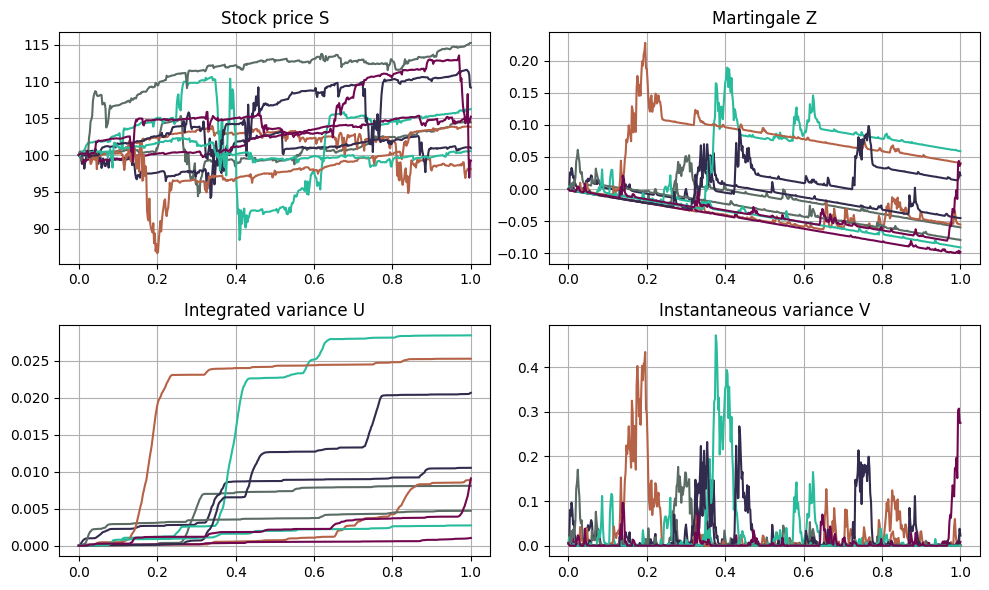

In [8]:
fig = plt.figure(figsize=(10, 6))
n_show = 10

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(t_grid, S[:, :n_show])
axs[0, 0].set_title('Stock price S')

axs[0, 1].plot(t_grid, Z[:, :n_show])
axs[0, 1].set_title('Martingale Z')

axs[1, 0].plot(t_grid, U[:, :n_show])
axs[1, 0].set_title('Integrated variance U')

axs[1, 1].plot(t_grid, V[:, :n_show])
axs[1, 1].set_title('Instantaneous variance V')

plt.show()

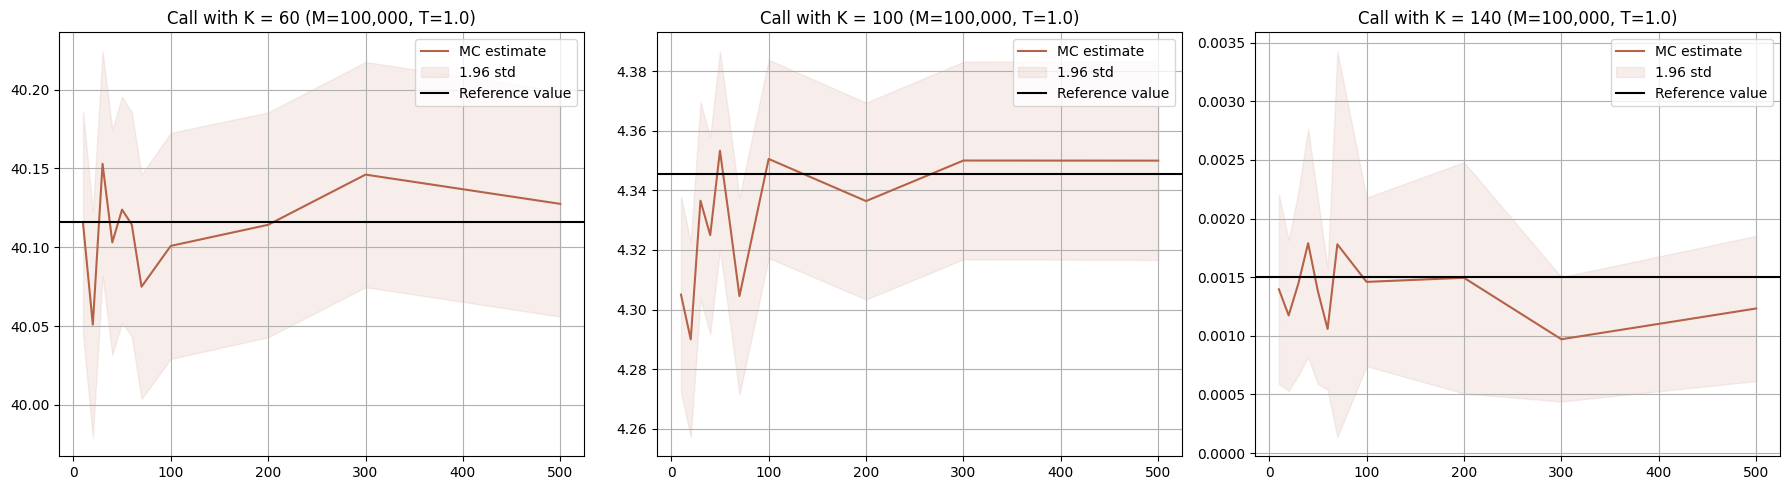

In [9]:
# Plot everything in one figure
start_idx = 1
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, name in enumerate(results):
    plot_with_ci(
        axs[i], n_steps_list[start_idx:], results[name]["mean"][start_idx:], results[name]["std"][start_idx:],
        n_paths, results[name]["ref"], f"{results[name]['label']} (M={n_paths:,}, T={T})"
    )

plt.tight_layout()
plt.show()

## Resolvent approach

The idea presented above can be easily generalized. Given the Volterra equation
$$
U_t = \int_0^t g_0(s)\, ds + \int_0^t K(t-s)\bigl(b U_s\, ds + c W_{U_s}\, ds\bigr),
$$
one can simplify it by removing the term linear in $U$ using the resolvent of the second kind $R_{bK}$ associated with the kernel $bK$. By convolving the equation with $(I + R_{bK})$ and performing straightforward simplifications, one obtains
$$
U_t = \int_0^t \int_0^s R_{bK}(s - r)\, g_0(r)\, dr\, ds
      + \int_0^t R_{bK}(t-s)\, \frac{c}{b}\, W_{U_s}\, ds,
$$
which is again a linear equation of the same form, with
$$
K^R = R_{bK}, \qquad
g_0^R(t) = \int_0^t R_{bK}(t - s)\, g_0(s)\, ds, \qquad
b^R = 0, \qquad
c^R = \frac{c}{b}.
$$

Below, we perform the same pricing exercise as above, viewing the standard Heston model as a Volterra Heston model with $K \equiv 1$. The exponential form derived above via the variation-of-constants formula is then nothing but the resolvent-based version of the iVi scheme.

In [10]:
V_0 = 0.006
a = 17.25 * 0.018
b = -17.25
c = 2.95
rho = -0.68
S0 = 100

kernel = ConstantKernel(c=1)
resolvent = ConstantKernel(c = b).resolvent

def g0_bar_res(t):
    return V_0 * resolvent.integrated_kernel(t) / b + a * resolvent.double_integrated_kernel(t) / b

def g0_bar(t):
    return V_0 * t + a * t**2 / 2

def g0(t):
    return V_0 + a * t


rng = np.random.default_rng(seed=42)
model = IVIVolterraVolModel(is_continuous=True, resolvent_flag=False, kernel=kernel,
                            g0_bar=g0_bar, rng=rng, b=b, c=c, g0=g0, rho=rho)
rng = np.random.default_rng(seed=42)
model_res = IVIVolterraVolModel(is_continuous=True, resolvent_flag=True, kernel=kernel,
                                g0_bar=g0_bar, g0_bar_res=g0_bar_res, rng=rng, b=b, c=c, g0=g0, rho=rho)

T = 1.

n_paths = 100_000
n_steps_list = [1, 10, 20, 30, 40, 50, 60, 70, 100, 200, 300, 500]

# Store results in a dictionary for clarity
results = {
    "call_K=60": {"mean": [], "std": [], "ref": 40.1163, "label": "Call with K = 60"},
    "call_K=100": {"mean": [], "std": [], "ref": 4.3454, "label": "Call with K = 100"},
    "call_K=140": {"mean": [], "std": [], "ref": 0.0015, "label": "Call with K = 140"},
}
results_res = deepcopy(results)

# Monte Carlo simulations
for n_steps in n_steps_list:
    t_grid = np.linspace(0, T, n_steps + 1)
    S, U, Z, V = model.simulate_price(t_grid=t_grid, n_paths=n_paths, S0=S0)
    # Call on price
    for K, name in zip([60, 100, 140], results.keys()):
        payoff = np.maximum(S[-1] - K, 0.0)
        results[name]["mean"].append(np.mean(payoff))
        results[name]["std"].append(np.std(payoff))

    S_res, U_res, Z_res, V_res = model_res.simulate_price(t_grid=t_grid, n_paths=n_paths, S0=S0)
    # Call on price
    for K, name in zip([60, 100, 140], results.keys()):
        payoff = np.maximum(S_res[-1] - K, 0.0)
        results_res[name]["mean"].append(np.mean(payoff))
        results_res[name]["std"].append(np.std(payoff))

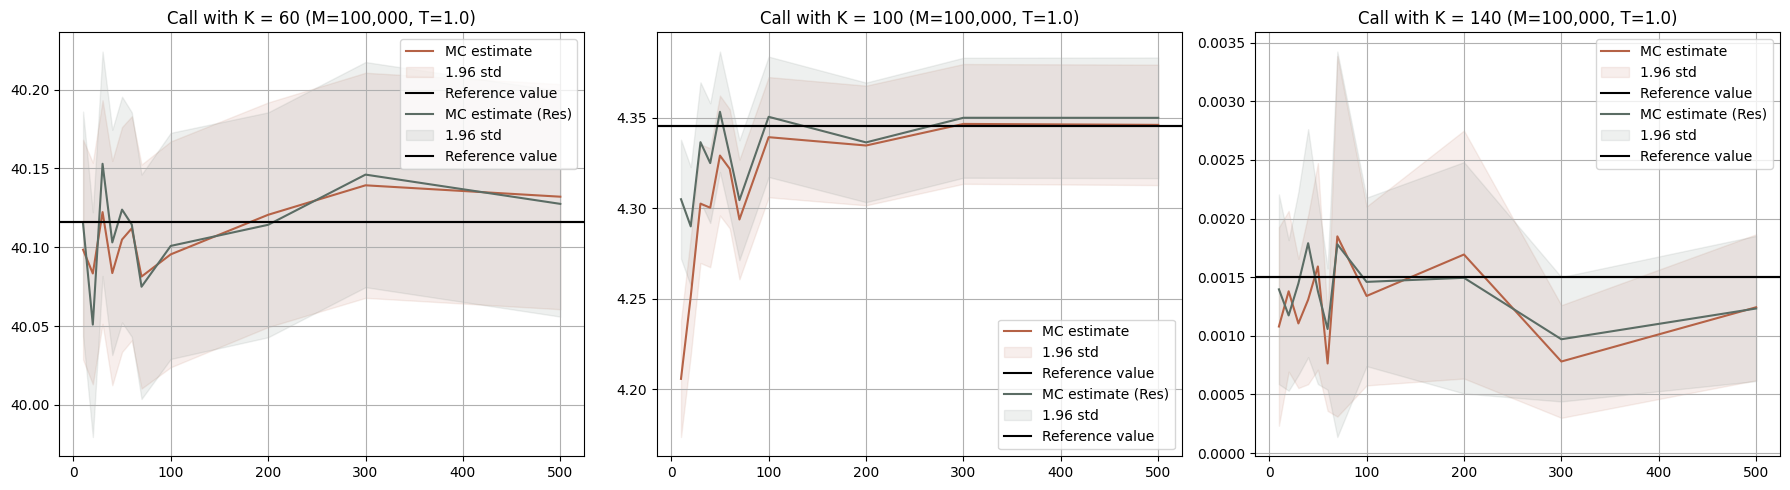

In [11]:
# Plot everything in one figure
start_idx = 1
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, name in enumerate(results):
    plot_with_ci(
        axs[i], n_steps_list[start_idx:], results[name]["mean"][start_idx:], results[name]["std"][start_idx:],
        n_paths, results[name]["ref"], f"{results[name]['label']} (M={n_paths:,}, T={T})"
    )
    plot_with_ci(
        axs[i], n_steps_list[start_idx:], results_res[name]["mean"][start_idx:], results_res[name]["std"][start_idx:],
        n_paths, results_res[name]["ref"], f"{results_res[name]['label']} (M={n_paths:,}, T={T})",
        label="MC estimate (Res)", color=color_cycle[0]
    )

plt.tight_layout()
plt.show()